## **Notebook PC#03**
## Regularized ELM Classifier for the MNIST and CIFAR-10 database. Designed from scratch.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Taylon Luan Congio Martins RA: 177379<br>
**Aluno(a):** Tiago C A Amorim RA: 100675

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from keras.datasets import mnist

(Xp, y), (Xtp, yt) = mnist.load_data()
Xa = Xp.reshape(Xp.shape[0], 784)
Xta = Xtp.reshape(Xtp.shape[0], 784)
X = Xa / 255.0
Xt = Xta / 255.0

print("Shape of X: ".ljust(10),  X.shape)
print("Shape of y: ".ljust(10),  y.shape)
print("Shape of Xt: ".ljust(10),  Xt.shape)
print("Shape of yt: ".ljust(10),  yt.shape)

11490434/11490434 [==============================] - 0s 0us/step
Shape of X:  (60000, 784)
Shape of y:  (60000,)
Shape of Xt:  (10000, 784)
Shape of yt:  (10000,)


In [ ]:
# Dataset balancing analysis
from tensorflow.keras.utils import to_categorical
import plotly.express as px

yy = to_categorical(y)
yyt = to_categorical(yt)
sum_along_columns1 = np.sum(yy, axis = 0)
print(sum_along_columns1)
sum_along_columns2 = np.sum(yyt, axis = 0)
print(sum_along_columns2)
fig1 = px.bar(x=range(10),y=sum_along_columns1, width=600, height=400,
              labels=dict(x="Class", y="Number of examples"), title="<b>Number of examples per class in the training dataset</b>")
fig1.update_layout(xaxis = dict(tickmode = 'linear', dtick = 1), title_x=0.5)
fig1.show()
fig2 = px.bar(x=range(10),y=sum_along_columns2, width=600, height=400,
              labels=dict(x="Class", y="Number of examples"), title="<b>Number of examples per class in the test dataset</b>")
fig2.update_layout(xaxis = dict(tickmode = 'linear', dtick = 1), title_x=0.5)
fig2.show()

[5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]
[ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]


In [ ]:
partition = 0.7

# Mixing the dataset before partitioning
index = np.arange(0,X.shape[0])
np.random.shuffle(index)

training_set_size = int(X.shape[0] * partition)

index_training = index[:training_set_size]
index_validation = index[training_set_size:]


X_training = X[index_training]
y_training = yy[index_training]

X_validation = X[index_validation]
y_validation = yy[index_validation]

# ELM X
# We will concatenate a column of 1's to account for the V0 of each hidden neuron later on
X_training_elm = np.concatenate((np.transpose(np.array([np.ones(X_training.shape[0])])), X_training), axis=1)
X_validation_elm = np.concatenate((np.transpose(np.array([np.ones(X_validation.shape[0])])), X_validation), axis=1)

print("X_training:".ljust(20), X_training.shape)
print("y_training:".ljust(20), y_training.shape)

print("X_validation:".ljust(20), X_validation.shape)
print("y_validation:".ljust(20), y_validation.shape)

print("X_training_elm:".ljust(20), X_training_elm.shape)
print("X_validation_elm:".ljust(20), X_validation_elm.shape)

X_training:          (42000, 784)
y_training:          (42000, 10)
X_validation:        (18000, 784)
y_validation:        (18000, 10)
X_training_elm:      (42000, 785)
X_validation_elm:    (18000, 785)


In [ ]:
def get_class_from_sample(sample: np.ndarray):
    class_ = 1
    for i in sample:
        if i == 0:
            class_ += 1
        else:
            break
    return class_

In [ ]:
def leaky_relu(table):
    return np.where(table > 0, table,  0.02 * table)

def relu(table):
    return np.where(table > 0, table,  0)

def get_h(X, V, activation_function):
    V_ = np.matmul(X, V)
    return activation_function(V_)

def get_w(X, y, c):
    w_1 = (np.matmul(np.transpose(X), X) + c * np.eye(X.shape[1]))
    w_2 = np.matmul(np.transpose(X), y)
    w,resid,rank,s = np.linalg.lstsq(w_1, w_2, rcond=None)
    return w

In [ ]:
def get_rates_from_c_values(X, y, c_values, Ws = []):
    hit_rates = []

    if len(Ws) != 0:
        are_Ws_given = True
    else:
        are_Ws_given = False
        Ws = []

    for index, c in enumerate(c_values):
        print(c)

        if are_Ws_given:
            W = Ws[index]
        else:
            W = get_w(X, y, c)
            Ws.append(W)

        y_estimate = np.matmul(X,W)
        hits = 0
        for index, estimate in enumerate(y_estimate):
            max_index = np.where(estimate == np.amax(estimate))[0][0]
            estimated_class = max_index + 1
            if estimated_class == get_class_from_sample(y[index]):
                hits += 1
        hit_rates.append(hits/y_estimate.shape[0])
    return hit_rates, Ws

In [ ]:
# Standard deviation of the random weight generation at the hidden layer
sigma = 0.2
# Number of inputs for the MNIST dataset: 785
# Take 1000 hidden neurons for the MNIST dataset
V  = sigma * np.random.randn(785, 1000)

In [ ]:
c_values = [pow(2,d) for d in range(-16, 15, 2)] # Range goes up to 15 to ensure search up to 2^14

hit_rates_training, Ws = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, c_values)

1.52587890625e-05
6.103515625e-05
0.000244140625
0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384


In [ ]:
hit_rates_validation, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, c_values, Ws)

1.52587890625e-05
6.103515625e-05
0.000244140625
0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384


Best c value: 16 
Performance of this value: 0.941


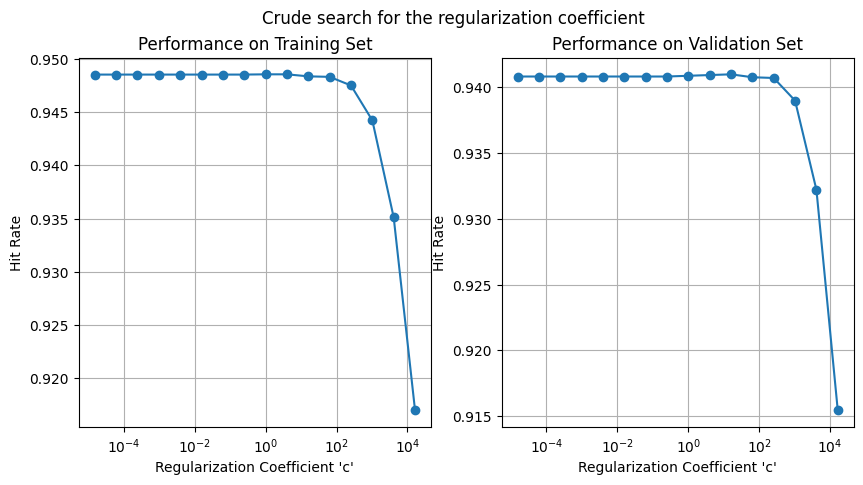

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training Set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation Set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation[best_c_index]))


**Nota**: Ao analisar o gráfico da direita acima, só corrija o intervalo de busca caso não haja uma queda de desempenho para valores elevados do coeficiente de regularização. Caso o melhor coeficiente de regularização seja o de menor valor, siga adiante, pois isso indica a ausência de necessidade de regularizar esta solução.

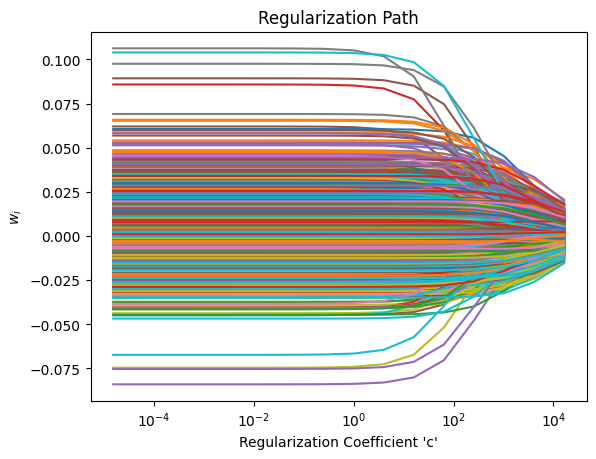

In [ ]:
lambd_values = c_values
w_values = Ws

def plot_regularization_path(lambd_values, w_values):
    num_coeffs = len(w_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in w_values])
    plt.xlabel(r"Regularization Coefficient 'c'", fontsize=10)
    plt.ylabel(r"$w_i$", fontsize=10)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()

plot_regularization_path(lambd_values, w_values)

<font color="green">
Atividade (a) <br>
Explique o comportamento das curvas [Regularization Path] e [Performance on Validation Set] logo acima, vinculando os seus comportamentos. <br>
</font>

Resposta: <br>
O método utilizado para encontrar o coeficiente de regularização (**C**) ótimo é o _crude search_, que se baseia no **C** que corresponde ao maior _hit rate_, ou seja, menor erro no conjunto de validação. Isto é observado no gráfico de _Performance on Validation Set_. O **C** _ótimo_ encontrado foi de 16 para um _hit rate_ de 0.941. Nota-se também que para valores maiores de **C** o _hit rate_ diminui, o que indica que a busca passou do ponto ótimo de **C**.<br>
No gráfico _Regularization Path_, observamos que para valores baixos de **C** os pesos são maiores em módulo e para valores maiores de **C** os pesos tendem a zero. Isto é esperado de acordo com a teoria, visto que o coeficiente de regularização é utilizado para diminuir os pesos sinápticos que estão relacionados com as _features_, e com isso controlar o _overfitting_ e garantir maior generalização do modelo.<br>
Também é possível notar no _Regularization Path_ que valores baixos de **C** tem muito pouco impacto nos pesos, o que é refletido na pouca variação do _hit-rate_ no começo do _Performance on Validation Set_. A partir de **C** igual a um existe um efeito mais perceptível de reduzir os valores absolutos dos pesos. No Início existe um efeito positivo no _hit-rate_, mas logo depois o efeito se reverte e o _hit-rate_ cai à medida que cresce **C** e os valores absolutos dos pesos caem.

In [ ]:
step =  0.1 * (4 * best_c - best_c / 4);

fine_c_values = np.arange((best_c/4), (4*best_c) + step / 10, step)

hit_rates_training_fine, Ws_fine = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, fine_c_values)

4.0
10.0
16.0
22.0
28.0
34.0
40.0
46.0
52.0
58.0
64.0


In [ ]:
hit_rates_validation_fine, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, fine_c_values, Ws_fine)

4.0
10.0
16.0
22.0
28.0
34.0
40.0
46.0
52.0
58.0
64.0


Best c value: 10.0 
Performance of this value: 0.941


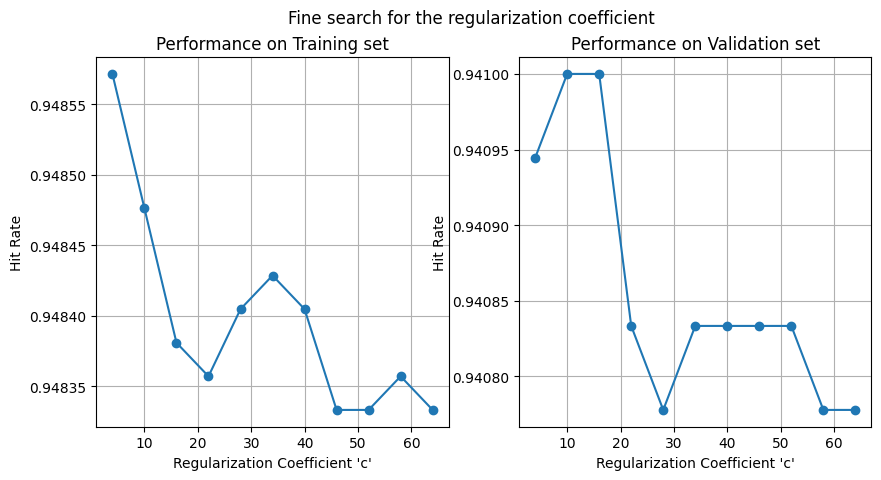

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Fine search for the regularization coefficient")
axs[0].plot(fine_c_values, hit_rates_training_fine, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].plot(fine_c_values, hit_rates_validation_fine, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation_fine == np.amax(hit_rates_validation_fine))[0][0]

best_c = fine_c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation_fine[best_c_index]))

In [ ]:
X_elm = np.concatenate((np.transpose(np.array([np.ones(X.shape[0])])), X), axis=1)
W_elm = get_w(get_h(X_elm, V, relu), yy, best_c)

In [ ]:
Xt_elm = np.concatenate((np.transpose(np.array([np.ones(Xt.shape[0])])), Xt), axis=1)
yt_estimate = np.matmul(get_h(Xt_elm, V, relu),W_elm)
hits = 0
confusion_matrix = np.zeros([10, 10], dtype=int)
for index, estimate in enumerate(yt_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == get_class_from_sample(yyt[index,:]):
        hits += 1
        confusion_matrix[estimated_class-1][estimated_class-1] += 1
    else:
        confusion_matrix[estimated_class-1][get_class_from_sample(yyt[index,:])-1] += 1

print("Performance on test set: {}".format(hits/yt_estimate.shape[0]))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
confusion_matrix_df

Performance on test set: 0.9431


,0,1,2,3,4,5,6,7,8,9
0,962,0,10,1,1,7,8,1,7,6
1,0,1121,2,0,7,1,2,16,5,8
2,2,5,950,10,4,2,1,20,5,2
3,1,2,10,948,0,23,0,1,14,15
4,0,1,7,2,919,2,7,9,6,27
5,3,1,1,15,0,824,12,1,13,2
6,7,3,12,1,8,13,927,1,11,1
7,1,0,13,9,1,7,0,952,7,10
8,2,2,24,15,5,7,1,1,899,9
9,2,0,3,9,37,6,0,26,7,929


<font color="green">
Atividade (b) <br>
O que sustenta o ganho de desempenho na taxa de acerto de classificação quando comparado ao classificador linear do PC01? Repare que a estratégia de otimização é a mesma nos dois casos. <br>
</font>

Resposta:<br>
O classificador linear gera uma fronteira de decisão linear para a classificação, e portanto está limitada a hiperplanos no espaço euclidiano, gerando menos capacidade de separação entre classes.<br>
Já a ELM (_extreme learning machine_) tem capacidade de gerar fronteiras de decisão não-lineares, assim permitindo que a superfície de separação entre classes se _contorça_ no espaço, ajudando na capacidade de separação entre classes.<br>
O conjunto de 1000 neurônios foi eficiente para que o classificador não-linear exibisse melhor desempenho.

Image no. 8


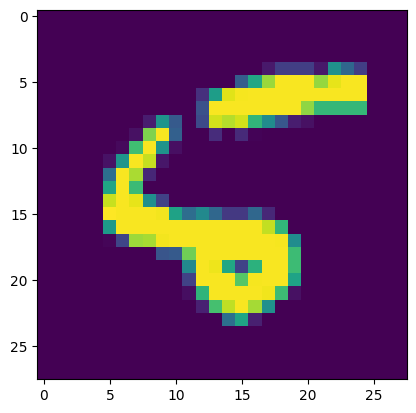

Real: 5
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.05244116  0.07163073  0.0674449  -0.14139911  0.21367391  0.3018689
  0.26084201 -0.08209935  0.01212727  0.33874806] 

Image no. 63


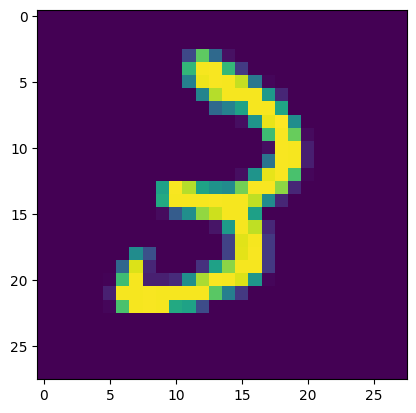

Real: 3
Predicted: 2
Rank of the correct answer: 2
Probabilities: [-0.03185209 -0.1024582   0.58326945  0.35934907  0.10217063  0.13216222
 -0.11782022 -0.112891    0.0711704   0.10614873] 

Image no. 65


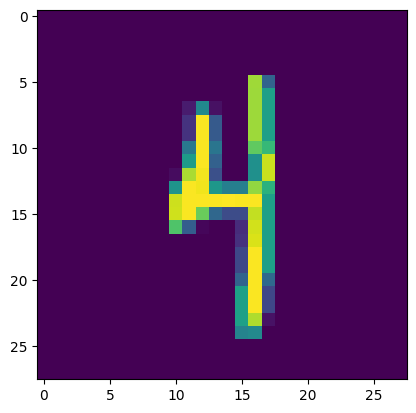

Real: 4
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.03330256  0.00572242 -0.00926884  0.00639181  0.3218295   0.13960571
  0.05998343 -0.01780206  0.00509314  0.35467052] 

Image no. 115


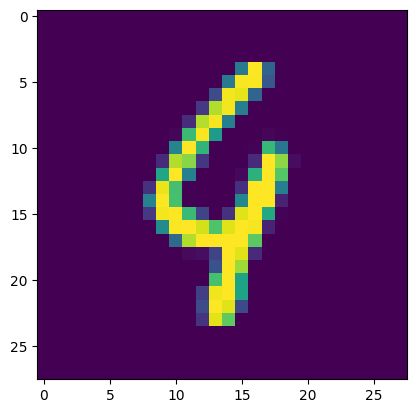

Real: 4
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.00964031  0.07241926  0.0082591  -0.12287679  0.34043357  0.01741149
  0.14719571  0.00859871 -0.00380376  0.52886014] 

Image no. 124


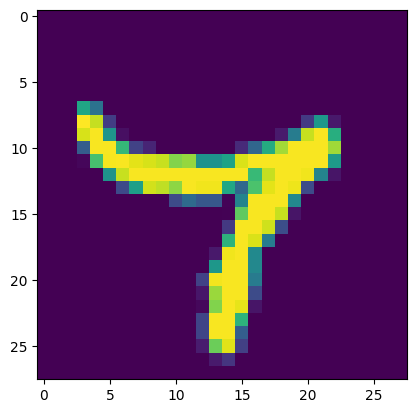

Real: 7
Predicted: 4
Rank of the correct answer: 2
Probabilities: [-0.0881143  -0.02017329 -0.15060211 -0.05139018  0.66343936  0.00232839
  0.10622168  0.27770759  0.15097992  0.11349828] 

Image no. 149


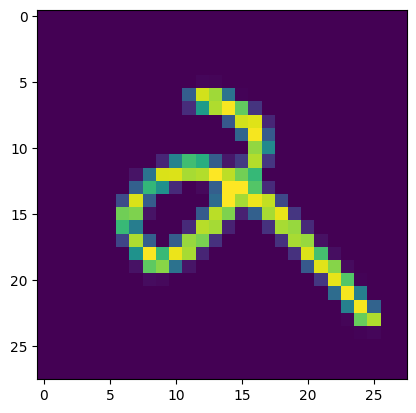

Real: 2
Predicted: 9
Rank of the correct answer: 7
Probabilities: [ 0.11412421 -0.00527373 -0.00683592  0.3203278   0.07894597 -0.11982178
  0.21864496 -0.11246577 -0.04384077  0.5035828 ] 

Image no. 193


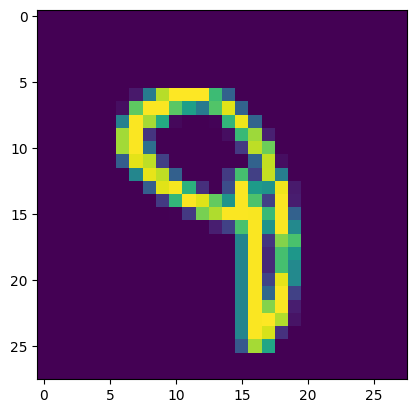

Real: 9
Predicted: 4
Rank of the correct answer: 2
Probabilities: [ 0.07008034 -0.11645818  0.04231555  0.17620017  0.43201641  0.03995075
 -0.02861283  0.12840171  0.03966532  0.19990596] 



In [ ]:
# Devoted solely to the MNIST dataset
def find_pos(item, lst):
    pos = [i for (z, i) in zip(lst, range(len(lst))) if item == z]
    return pos

def display_sample(sample: np.ndarray):

    sample = np.array(sample, dtype='float')
    pixels = np.zeros((28,28))

    for i in range(28):
        for j in range(28):
            pixels[i,j] = sample[i * 28 + j]

    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='viridis')
    plt.show()

yt_estimate = np.matmul(get_h(Xt_elm, V, relu),W_elm)
for i in range(200):
    if yyt[i][np.argmax(yt_estimate[i,:])] != 1:
      print(f"Image no. {i}")
      display_sample(Xt[i])
      print(f"Real: {np.argmax(yyt[i,:])}")
      print(f"Predicted: {np.argmax(yt_estimate[i,:])}")
      value = yt_estimate[i,np.argmax(yyt[i,:])]
      v_sorted = np.sort(yt_estimate[i,:])
      value_index = find_pos(value,v_sorted)
      print(f"Rank of the correct answer: {10 - value_index[0]}")
      print(f"Probabilities: {yt_estimate[i,:]} \n")

##Repetindo os principais passos, agora para a base CIFAR-10.

In [ ]:
from keras.datasets import cifar10

(Xp, y), (Xtp, yt) = cifar10.load_data()
Xa = Xp.reshape(Xp.shape[0], 3072)
Xta = Xtp.reshape(Xtp.shape[0], 3072)
y = y.ravel()
yt = yt.ravel()
X = Xa / 255.0
Xt = Xta / 255.0

print("Shape of X: ".ljust(10),  X.shape)
print("Shape of y: ".ljust(10),  y.shape)
print("Shape of Xt: ".ljust(10),  Xt.shape)
print("Shape of yt: ".ljust(10),  yt.shape)

yy = to_categorical(y)
yyt = to_categorical(yt)

170498071/170498071 [==============================] - 2s 0us/step
Shape of X:  (50000, 3072)
Shape of y:  (50000,)
Shape of Xt:  (10000, 3072)
Shape of yt:  (10000,)


In [ ]:
partition = 0.7

# Mixing the dataset before partitioning
index = np.arange(0,X.shape[0])
np.random.shuffle(index)

training_set_size = int(X.shape[0] * partition)

index_training = index[:training_set_size]
index_validation = index[training_set_size:]


X_training = X[index_training]
y_training = yy[index_training]

X_validation = X[index_validation]
y_validation = yy[index_validation]

# ELM X
# We will concatenate a column of 1's to account for the V0 of each hidden neuron later on
X_training_elm = np.concatenate((np.transpose(np.array([np.ones(X_training.shape[0])])), X_training), axis=1)
X_validation_elm = np.concatenate((np.transpose(np.array([np.ones(X_validation.shape[0])])), X_validation), axis=1)

print("X_training:".ljust(20), X_training.shape)
print("y_training:".ljust(20), y_training.shape)

print("X_validation:".ljust(20), X_validation.shape)
print("y_validation:".ljust(20), y_validation.shape)

print("X_training_elm:".ljust(20), X_training_elm.shape)
print("X_validation_elm:".ljust(20), X_validation_elm.shape)

X_training:          (35000, 3072)
y_training:          (35000, 10)
X_validation:        (15000, 3072)
y_validation:        (15000, 10)
X_training_elm:      (35000, 3073)
X_validation_elm:    (15000, 3073)


In [ ]:
# Standard deviation of the random weight generation at the hidden layer
sigma = 0.2
# Number of inputs for the CIFAR10 dataset: 3073
# Take 2000 hidden neurons for the CIFAR10 dataset.
V  = sigma * np.random.randn(3073, 2000)

In [ ]:
c_values = [pow(2,d) for d in range(-8, 21, 2)] # Range goes up to 21 to ensure search up to 2^20

hit_rates_training, Ws = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, c_values)

0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384
65536
262144
1048576


In [ ]:
hit_rates_validation, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, c_values, Ws)

0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384
65536
262144
1048576


Best c value: 1024 
Performance of this value: 0.45713333333333334


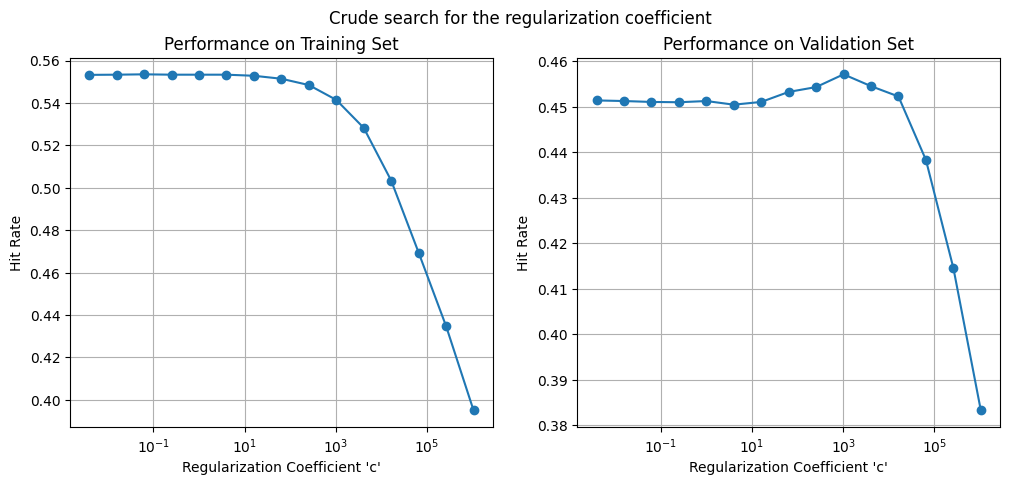

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training Set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation Set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation[best_c_index]))


**Nota**: Ao analisar o gráfico da direita acima, só corrija o intervalo de busca caso não haja uma queda de desempenho para valores elevados do coeficiente de regularização. Caso o melhor coeficiente de regularização seja o de menor valor, siga adiante, pois isso indica a ausência de necessidade de regularizar esta solução.

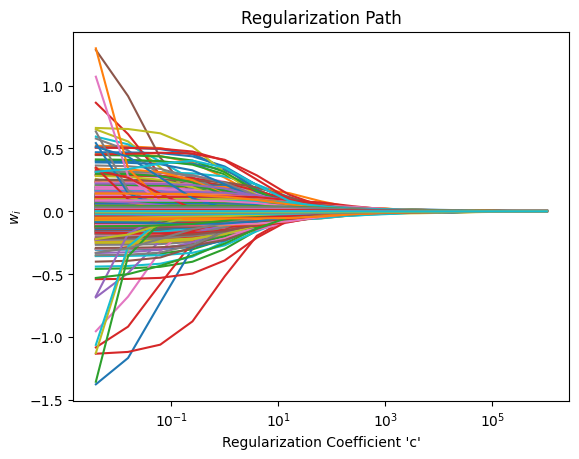

In [ ]:
lambd_values = c_values
w_values = Ws

def plot_regularization_path(lambd_values, w_values):
    num_coeffs = len(w_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in w_values])
    plt.xlabel(r"Regularization Coefficient 'c'", fontsize=10)
    plt.ylabel(r"$w_i$", fontsize=10)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()

plot_regularization_path(lambd_values, w_values)

In [ ]:
step =  0.1 * (4 * best_c - best_c / 4);

fine_c_values = np.arange((best_c/4), (4*best_c) + step / 10, step)

hit_rates_training_fine, Ws_fine = get_rates_from_c_values(get_h(X_training_elm, V, relu), y_training, fine_c_values)

256.0
640.0
1024.0
1408.0
1792.0
2176.0
2560.0
2944.0
3328.0
3712.0
4096.0


In [ ]:
hit_rates_validation_fine, _ = get_rates_from_c_values(get_h(X_validation_elm, V, relu), y_validation, fine_c_values, Ws_fine)

256.0
640.0
1024.0
1408.0
1792.0
2176.0
2560.0
2944.0
3328.0
3712.0
4096.0


Best c value: 1408.0 
Performance of this value: 0.45753333333333335


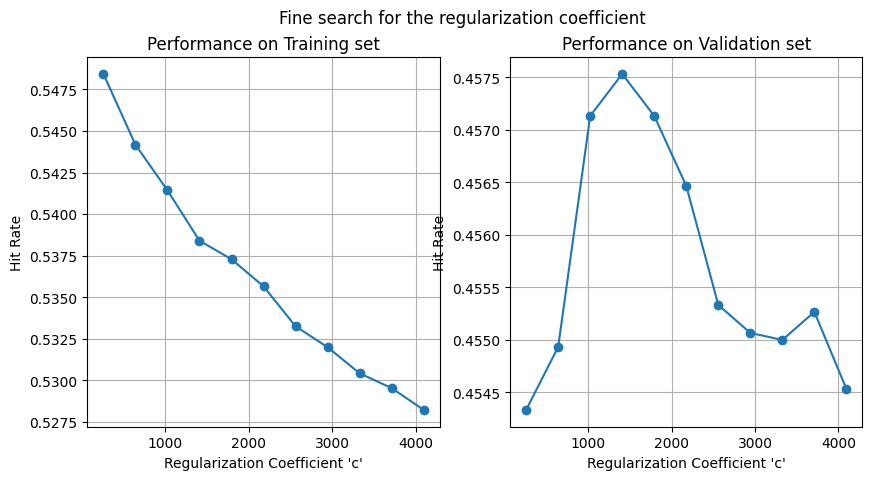

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Fine search for the regularization coefficient")
axs[0].plot(fine_c_values, hit_rates_training_fine, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].plot(fine_c_values, hit_rates_validation_fine, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation_fine == np.amax(hit_rates_validation_fine))[0][0]

best_c = fine_c_values[best_c_index]

print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation_fine[best_c_index]))

In [ ]:
X_elm = np.concatenate((np.transpose(np.array([np.ones(X.shape[0])])), X), axis=1)
W_elm = get_w(get_h(X_elm, V, relu), yy, best_c)

In [ ]:
Xt_elm = np.concatenate((np.transpose(np.array([np.ones(Xt.shape[0])])), Xt), axis=1)
yt_estimate = np.matmul(get_h(Xt_elm, V, relu),W_elm)
hits = 0
confusion_matrix = np.zeros([10, 10], dtype=int)
for index, estimate in enumerate(yt_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == get_class_from_sample(yyt[index,:]):
        hits += 1
        confusion_matrix[estimated_class-1][estimated_class-1] += 1
    else:
        confusion_matrix[estimated_class-1][get_class_from_sample(yyt[index,:])-1] += 1

print("Performance on test set: {}".format(hits/yt_estimate.shape[0]))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
confusion_matrix_df

Performance on test set: 0.4693


,0,1,2,3,4,5,6,7,8,9
0,537,36,106,45,67,28,19,34,96,39
1,44,566,38,58,26,40,43,52,69,185
2,45,13,313,72,132,83,65,43,11,12
3,14,21,67,246,40,156,59,49,18,21
4,23,12,106,54,352,75,90,70,10,6
5,12,17,71,187,48,354,53,59,24,28
6,36,35,130,157,159,103,587,40,16,35
7,40,40,82,65,107,82,39,537,20,53
8,192,83,47,44,48,43,20,32,664,84
9,57,177,40,72,21,36,25,84,72,537


<font color="green">
Atividade (c) <br>
No link a seguir, afirma-se que uma das vantagens das ELMs é que elas [can learn from the training data in one step, without repeating the learning process in multiple steps.] Não foi o que fizemos neste PC03. Qual é o risco de treinar uma ELM em apenas um passo? <br>
</font>

[Extreme Learning Machine - Advantage of ELM](https://www.geeksforgeeks.org/extreme-learning-machine/)

Resposta:<br>
A ELM possui uma caracterísitca aleatória, o que a destaca em comparação com a rede linear. Na ELM os pesos sinápticos e bias da camada única de _hidden layers_ são inicializados com valores aleatórios. Existe um ganho de evitar a necessidade de processos iterativos, o que acelera o processo de treinamento. O porém da ELM é, por não ajustar os pesos sinápticos, a sua incapacidade de obter _features_ mais precisas, que consumam menos recursos e até acabar trabalhando com _features_ que podem ser inúteis ao modelo.

Ao fazer um único treinamento de uma ELM pode-se (devido à aleatoridade ou falta de melhor definição do termo de regularização) construir um modelo sub-ótimo, e não utilizar de maneira mais adequada as capacidades deste tipo de rede. O exemplo com a base CIFAR-10 é bastante elucidativo, mostrando que é preciso testar a rede com diferentes valores do termo de regularização. Adicionalmente, devido à aleatoriedade com que os pesos internos dos neurônios são definidos, pode ser uma boa prática inicializar estes pesos com diferentes estratégias (variando sigma, por exemplo).

De toda forma acredito que o autor fez a afirmação comparando o uso da formulação fechada, possível com ELM, em comparação com métodos iterativos, que demandam vários passos de treinamento.

<font color="green">
Atividade (d) <br>
Uma vez treinada uma ELM, que estratégia você adotaria para eliminar neurônios da camada intermediária, caso uma implementação prática indicasse uma limitação de memória? A sua resposta deve propor uma subrede ELM extraída da rede ELM completa já treinada, capaz de exibir máximo desempenho de generalização. Considere que o número de neurônios que precisam ser eliminados é uma porcentagem arbitrária do número total. Considere também que a sua estratégia não deve se basear na amplitude dos pesos individuais da camada de saída (essa seria uma estratégia possível, mas não deve ser adotada aqui). <br>
</font>

Resposta: <br>
A matriz de ativação da ELM é dada por:<br>
\begin{align}
H =
\begin{pmatrix}
1 & f(\vec{v_1}, b_1, \vec{x_1}) & f(\vec{v_2}, b_2, \vec{x_1}) & ... & f(\vec{v_n}, b_n, \vec{x_1})\\
1 & f(\vec{v_1}, b_1, \vec{x_2})& ... & ... & ...\\
... & ... & ... & ... & ...\\
1 & f(\vec{v_1}, b_1, \vec{x_N})& ... & ... & f(\vec{v_n}, b_n, \vec{x_N})
\end{pmatrix}
\end{align}
<br>
Onde cada coluna corresponde a um neurônio, para uma rede com $n$ neurônios e $N$ atributos (excluindo o atributo *dummmy*).<br>
Após treinada a ELM, a fim de otimizar o uso de memória, podemos analisar cada vetor coluna e imputarmos métricas para exclusão de colunas, pois excluir colunas implica em excluir neurônios da rede.<br>
Uma métrica sugerida é o valor médio de cada coluna (soma-se todos os valores da coluna e divide por $N$), assim podemos ver a ativação média de cada neurônio e então compará-lo com a média geral (soma-se a média de todos neurônios e divide por $n$).
Porém, esta métrica estaria sujeita a variância dos valores dentro do neurônio e usá-la exclusivamente poderia excluir, por exemplo, um neurônio com um alto valor de ativação para apenas um atributo. Para evitar esse resultado, pode-se incluir uma métrica que não exclua neurônios com valor de ativação mínimo para um atributo, e então combinando essas duas métricas numa condicional (AND) podemos ajustar esses valores limiares de média e valor mínimo tal quanto desejarmos otimizarmos a rede.<br>
Outra métrica sugerida é o valor da norma euclidiana de cada coluna, para valores minimos de um limiar configurado pelo programador, pode-se excluir tal coluna. Esta pode ser uma única condição para exclusão de colunas.<br>
Todas essas métricas devem ser comparadas a valores médios de toda a rede (norma média, média geral, mínimo médio), para que faça sentido a otimização retirando neurônios.<br>
A combinação dessas métricas e seus respectivos valores dependerá de quanto queremos otimizar a rede.<br>
<br>
Considerando especificamente o exemplo acima, temos uma função de ativação Relu. A Relu retorna o máximo entre zero o valor de entrada, e uma proposta de redução da rede é buscar neurônios que gerem sempre zero, pois estes não terão impacto no produto interno que é feito posteriormente (adequando os pesos da camada de saída adequadamente, é claro).<br>
Os dados de entrada estão todos entre 0 e 1, de forma que neurônios com todos os seus pesos negativos ($\vec{v_i}<0$ e $b_i<0$) nunca irão gerar nada além de zeros, e não contribuem para os resultados da ELM.<br>
Como o primeiro elemento do vetor de entrada é sempre a unidade, neurônios que tem um valor muito negativo associado a esta entrada ($b_i$) e cuja soma dos pesos positivos seja baixa (menor que o absoluto do peso associado à unidade) também irão sempre gerar valores zero.<br>
Uma última estratégia é avaliar o resultado da multiplicação do conjunto de entrada com os pesos internos dos neurônios somado dos bias, e cortar os neurônios associados às colunas desta matriz resultante que tem apenas valores negativos (equivalente a colunas com zeros apenas na matriz $H$ acima).